In [6]:
from scipy.optimize import minimize
import numpy as np
from scipy.linalg import block_diag
import time

# give the 1,2 norm of a vector in 2d
def norm12(x):
    norm = 0
    for i in range(int(len(x)/2)):
        norm = norm + np.sqrt(x[2*i]**2 + x[2*i+1]**2)
    return norm


#make sure n and d are even
n = 10000
d = 50

def gen_train_data(n, d):
    A = np.zeros((n,d),dtype=np.complex_)
    x = np.zeros((d,1),dtype=np.complex_)
    y = np.zeros((n,1),dtype=np.complex_)
    for i in range(n):
        for j in range(d):
            a = np.random.rand()*10
            b = np.random.rand()*10
            A[i,j]=complex(a,b)

    for i in range(d):
        a = np.random.rand()
        b = np.random.rand()
        x[i] = complex(a,b)

    exact_res = 0
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        exact_res = exact_res + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (A, x, y, exact_res)

    
def gen_test(n, d, A, x):  
    noise = 0
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        noise = noise + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (y, noise)

def gen_rand_test(n, d, x):  
    noise = 0
    A = np.zeros((n,d),dtype=np.complex_)

    for i in range(n):
        for j in range(d):
            a = np.random.rand()*10
            b = np.random.rand()*10
            A[i,j]=complex(a,b)
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        noise = noise + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (A, y, noise)

def unfold_mat(A):
    n = A.shape[0]*2
    d = A.shape[1]*2
    B = np.zeros((n, d))
    for i in range(int(n/2)):
        for j in range(int(d/2)):
            curr = A[i, j]
            a = curr.real
            b = curr.imag
            B[2*i, 2*j] = a
            B[2*i, 2*j+1] = b
            B[2*i+1, 2*j] = -b
            B[2*i+1, 2*j+1] = a
    return B

def unfold_vec(x):
    d = x.shape[0]*2
    y = np.zeros((d, 1))
    for i in range(int(d/2)):
        curr = x[i]
        a = curr.real
        b = curr.imag
        y[2*i]= a
        y[2*i+1] = b
    return y

def gen_gaussian(k, t, n):
    block_list = []
    G = np.random.randn(k, t) / k*np.sqrt(np.pi/2)
    for i in range(n):
        
        block_list.append(G)
    return block_diag(*block_list)


In [7]:
from l1 import l1
import cvxopt
from cvxopt import normal

(A, x, y, train_noise)=gen_train_data(n,d)

AA = unfold_mat(A)
yy = unfold_vec(y)

true_y = unfold_vec(y)

ks = [2,4,6,8,10,20,40]
ds = [20, 25, 30, 35, 40, 45, 50, 80]
rep = 2
total_res_list = []
total_approx_list = []
noise = 0

G = gen_gaussian(4, 2, n)
for d in ds:
    print(d)
    total_res = 0.0
    curr_approx = 0
    start_time = time.time()

    # generate training data depending on d
    (A, x, y, train_noise)=gen_train_data(n,d)
    AA = unfold_mat(A)
    yy = unfold_vec(y)
    xx = unfold_vec(x)
    AAA = cvxopt.matrix(np.dot(G, AA))
    yyy = cvxopt.matrix(np.dot(G, yy))
    x_hat1 = l1(AAA, yyy)
    for it in range(rep):
        (At, y_test, test_noise)=gen_rand_test(n, d, x)
        At = unfold_mat(At)
        y_hat1 = At.dot(x_hat1)
        y_test = unfold_vec(y_test)
        
        y_true = np.dot(At, xx)
        curr_fit1 = norm12(y_hat1-y_true)[0]

        curr_approx = curr_approx + (curr_fit1)

    total_approx_list.append(curr_approx/rep)
    print("--- %s seconds ---" % (time.time() - start_time))




20
--- 6.427711248397827 seconds ---
25
--- 6.0663001537323 seconds ---
30
--- 6.7172558307647705 seconds ---
35
--- 8.247327089309692 seconds ---
40
--- 8.753105878829956 seconds ---
45
--- 11.530364990234375 seconds ---
50
--- 8.827115058898926 seconds ---
80
--- 17.006563186645508 seconds ---


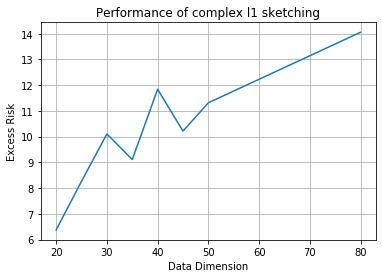

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(ds, total_approx_list)

ax.set(xlabel='Data Dimension', ylabel='Excess Risk',
       title='Performance of complex l1 sketching')
ax.grid()

fig.savefig("test.png")
plt.show()



